In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls 'gdrive/MyDrive/TSAI_END2/Session5/stanfordSentimentTreebank'

datasetSentences.txt  dictionary.txt		sentiment_labels.txt  test.txt
datasetSplit.txt      original_rt_snippets.txt	SOStr.txt	      train.txt
dev.txt		      README.txt		STree.txt	      trees


In [ ]:
!pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=2a7fd00852ad6063de352e950e38caa128d2c8f99acf1d148716fc794c3f6d1c
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


In [ ]:
!pip install nltk==3.4

     |████████████████████████████████| 1.4MB 5.5MB/s 
  Created wheel for nltk: filename=nltk-3.4-cp37-none-any.whl size=1436399 sha256=c111892495a40efc58eecc0163c3eebcee346c000ecc5d8dd4a7826146becdfa
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import os

out_path = os.path.join('gdrive/MyDrive/TSAI_END2/Session5/data/', 'sst_{}.txt')
sst_path = 'gdrive/MyDrive/TSAI_END2/Session5/stanfordSentimentTreebank'

## Dataset Creation
---

#### Visualize SST

In [ ]:
import pytreebank
# load the sentiment treebank corpus in the parenthesis format,
# e.g. "(4 (2 very ) (3 good))"
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["train"][0]
# display it in the page
example.display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load data
import pytreebank
import sys
import os

dataset = pytreebank.load_sst(sst_path)

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1, # label
                item.to_labeled_lines()[0][1] # sentence
            ))
# Print the length of the training set
print(len(dataset['train']))

8544


## EDA
---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download these NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk, time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import collections, itertools

In [ ]:
# Read train data
train_df = pd.read_csv(out_path.format('train'), sep='\t', header=None, names=['label', 'text'])
train_df['label'] = train_df['label'].str.replace('__label__', '')
train_df['label'] = train_df['label'].astype(int).astype('category')

# Read test data
test_df = pd.read_csv(out_path.format('test'), sep='\t', header=None, names=['label', 'text'])
test_df['label'] = test_df['label'].str.replace('__label__', '')
test_df['label'] = test_df['label'].astype(int).astype('category')

# Read evaluation data
eval_df = pd.read_csv(out_path.format('dev'), sep='\t', header=None, names=['label', 'text'])
eval_df['label'] = eval_df['label'].str.replace('__label__', '')
eval_df['label'] = eval_df['label'].astype(int).astype('category')

print('Sample training data:')
print(train_df.head())
print(f' Data Size: {len(train_df)}')
print('\n')

print('Sample test data:')
print(test_df.head())
print(f' Data Size: {len(test_df)}')
print('\n')

print('Sample evaluation data:')
print(eval_df.head())
print(f' Data Size: {len(eval_df)}')

Sample training data:
  label                                               text
0     4  The Rock is destined to be the 21st Century 's...
1     5  The gorgeously elaborate continuation of `` Th...
2     4  Singer/composer Bryan Adams contributes a slew...
3     3  You 'd think by now America would have had eno...
4     4               Yet the act is still charming here .
 Data Size: 8544


Sample test data:
  label                                               text
0     3                     Effective but too-tepid biopic
1     4  If you sometimes like to go to the movies to h...
2     5  Emerges as something rare , an issue movie tha...
3     3  The film provides some great insight into the ...
4     5  Offers that rare combination of entertainment ...
 Data Size: 2210


Sample evaluation data:
  label                                               text
0     4  It 's a lovely film with lovely performances b...
1     3  No one goes unindicted here , which is probabl...
2     4  And 

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Training Data', x=train_df['label'].value_counts(sort=False).index.tolist(), y=train_df['label'].value_counts(sort=False).values.tolist(), text=train_df['label'].value_counts(sort=False).values.tolist(), textposition='auto'),
    go.Bar(name='Test Data', x=test_df['label'].value_counts(sort=False).index.tolist(), y=test_df['label'].value_counts(sort=False).values.tolist(), text=test_df['label'].value_counts(sort=False).values.tolist(), textposition='auto'),
    go.Bar(name='Evaluation Data', x=eval_df['label'].value_counts(sort=False).index.tolist(), y=eval_df['label'].value_counts(sort=False).values.tolist(), text=eval_df['label'].value_counts(sort=False).values.tolist(), textposition='auto'),
])
# Change the bar mode
fig.update_layout(barmode='group',title_text='Sentence Distribution Across 1 to 5 Sentiments', xaxis=dict(title='Sentiment Label'), yaxis=dict(title='Number of samples'))
fig.show()

In [ ]:
# Function to tokenize the tweets
def custom_tokenize(text):
    """Function that tokenizes text"""
    from nltk.tokenize import word_tokenize
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return word_tokenize(text)

# Function that applies the cleaning steps
def clean_up(data1):
    """Function that cleans up the data into a shape that can be further used for modeling"""
    data = data1.copy()
    tokenized = data['text'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words
    data['cleaned_text'] = no_stops
    return data

In [ ]:
train_df_cleaned = clean_up(train_df)
test_df_cleaned = clean_up(test_df)
eval_df_cleaned = clean_up(eval_df)

In [ ]:
print('Sample training data:')
print(train_df_cleaned.head())
print(f' Data Size: {len(train_df_cleaned)}')
print('\n')

print('Sample test data:')
print(test_df_cleaned.head())
print(f' Data Size: {len(test_df_cleaned)}')
print('\n')

print('Sample evaluation data:')
print(eval_df_cleaned.head())
print(f' Data Size: {len(eval_df_cleaned)}')

Sample training data:
  label  ...                                       cleaned_text
0     4  ...  [rock, destined, century, new, conan, going, m...
1     5  ...  [gorgeously, elaborate, continuation, lord, ri...
2     4  ...  [bryan, adams, contributes, slew, songs, poten...
3     3  ...  [think, america, would, enough, plucky, britis...
4     4  ...                        [yet, act, still, charming]

[5 rows x 3 columns]
 Data Size: 8544


Sample test data:
  label  ...                                       cleaned_text
0     3  ...                                [effective, biopic]
1     4  ...  [sometimes, like, go, movies, fun, wasabi, goo...
2     5  ...  [emerges, something, rare, issue, movie, hones...
3     3  ...  [film, provides, great, insight, neurotic, min...
4     5  ...  [offers, rare, combination, entertainment, edu...

[5 rows x 3 columns]
 Data Size: 2210


Sample evaluation data:
  label  ...                                       cleaned_text
0     4  ...  [lovely,

In [ ]:
train_df_cleaned['type'] = 'Training Data'
test_df_cleaned['type'] = 'Test Data'
eval_df_cleaned['type'] = 'Evaluation Data'

df = pd.concat([train_df_cleaned,test_df_cleaned,eval_df_cleaned], axis=0)
print(f'Entire Data Size: {len(df)}')

Entire Data Size: 11855


#### Number of words in each sentence

In [ ]:
# # Number of words in each sentence
# _ = test_df_cleaned['cleaned_text'].str.len().hist(grid=False, figsize=(9,7), bins=20)
# _ = plt.xlabel('Number of words')
# _ = plt.ylabel('Frequency')
# _ = plt.title('Number of words in each sentence')
# plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3)

trace0 = go.Histogram(x=train_df_cleaned['cleaned_text'].str.len(),autobinx=False,name='Training Data')
trace1 = go.Histogram(x=test_df_cleaned['cleaned_text'].str.len(),autobinx=False,name='Test Data')
trace2 = go.Histogram(x=eval_df_cleaned['cleaned_text'].str.len(),autobinx = False,name='Evaluation Data')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

fig.update_layout(title_text='Number of words in each sentence', xaxis=dict(title='Number of words'), yaxis=dict(title='Frequency'))

fig.show()

In [ ]:
import plotly.express as px

df['sent_len'] = df['cleaned_text'].str.len()
  
fig = px.histogram(df, x="sent_len", color = "type", marginal = 'box', labels={'sent_len':'Number of words', 'y':'Frequency'}, title='Number of words in each sentence')
fig.show()

#### Average word length in each sentence

In [ ]:
# # let's check the average word length in each sentence
# _ = train_df_cleaned['cleaned_text'].apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)).hist(grid=False, bins=20, figsize=(9,7))
# _ = plt.xlabel('Average length of word in each sentence')
# _ = plt.ylabel('Frequency')
# _ = plt.title('Average word length across sentences')
# plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3)

trace0 = go.Histogram(x=train_df_cleaned['cleaned_text'].apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)),autobinx=False,name='Training Data')
trace1 = go.Histogram(x=test_df_cleaned['cleaned_text'].apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)),autobinx=False,name='Test Data')
trace2 = go.Histogram(x=eval_df_cleaned['cleaned_text'].apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)),autobinx = False,name='Evaluation Data')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

fig.update_layout(title_text='Average word length across sentences', xaxis=dict(title='Average length of word in each sentence'), yaxis=dict(title='Frequency'))

fig.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.



In [ ]:
import plotly.express as px

df['avg_word_len'] = df['cleaned_text'].apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y))
  
fig = px.histogram(df, x="avg_word_len", color = "type", marginal = 'box', labels={'avg_word_len':'Average word length in each sentence', 'y':'Frequency'}, title='Average word length across sentences')
fig.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.



#### Create Bag of Words using Gensim

In [ ]:
sentences = df['cleaned_text']
train_sentences = train_df_cleaned['cleaned_text']
test_sentences = test_df_cleaned['cleaned_text']
eval_sentences = eval_df_cleaned['cleaned_text']

In [ ]:
# Import Dictionary
from gensim.corpora.dictionary import Dictionary
# Create a Dictionary from the sentences
start = time.time()
dictionary = Dictionary(sentences)
train_dictionary = Dictionary(train_sentences)
test_dictionary = Dictionary(test_sentences)
eval_dictionary = Dictionary(eval_sentences)
end = time.time()
total = end-start
print(f'dictionary created in {total} seconds')

# Create corpus for bag of words (token IDs of each word with their frequencies)
start = time.time()
corpus = sentences.apply(lambda x: dictionary.doc2bow(x))
train_corpus = sentences.apply(lambda x: train_dictionary.doc2bow(x))
test_corpus = sentences.apply(lambda x: test_dictionary.doc2bow(x))
eval_corpus = sentences.apply(lambda x: eval_dictionary.doc2bow(x))
end = time.time()
total = end-start
print(f'corpus created in {total} seconds')

dictionary created in 0.3423473834991455 seconds
corpus created in 0.523878812789917 seconds


In [ ]:
corpus

0       [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
1       [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), ...
2       [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), ...
3       [(50, 1), (51, 1), (52, 1), (53, 1), (54, 1), ...
4                    [(59, 1), (60, 1), (61, 1), (62, 1)]
                              ...                        
1096    [(195, 1), (217, 1), (230, 1), (509, 1), (528,...
1097    [(65, 1), (166, 1), (167, 1), (225, 1), (232, ...
1098    [(178, 1), (560, 1), (708, 1), (709, 1), (902,...
1099    [(159, 1), (375, 1), (402, 1), (1060, 1), (566...
1100    [(159, 1), (166, 1), (178, 1), (469, 1), (967,...
Name: cleaned_text, Length: 11855, dtype: object

In [ ]:
import collections, itertools
start = time.time()

total_word_count = collections.defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id]+=word_count
    
end = time.time()
total = end-start
print(f'total words counted in {total} seconds')

start = time.time()

sorted_bow = sorted(total_word_count.items(), key=lambda kv :kv[1], reverse=True)
words = []
word_counts = []
for word_id, word_count in sorted_bow[:20]:
    words.append(dictionary.get(word_id)) 
    word_counts.append(word_count)
    
end = time.time()
total = end-start
print(f'top 20 words counted in {total} seconds')

total words counted in 0.02971482276916504 seconds
top 20 words counted in 0.011717081069946289 seconds


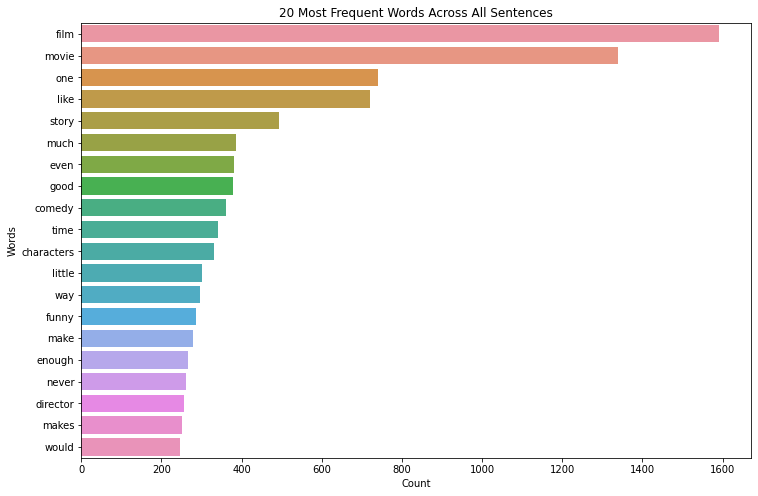

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=word_counts, y=words)
fig = plt.xlabel("Count")
fig = plt.ylabel('Words')
fig = plt.title('20 Most Frequent Words Across All Sentences')
plt.show()

In [ ]:
def count_word(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id]+=word_count
  
  sorted_bow = sorted(total_word_count.items(), key=lambda kv :kv[1], reverse=True)
  words = []
  word_counts = []
  for word_id, word_count in sorted_bow[:20]:
      words.append(dictionary.get(word_id)) 
      word_counts.append(word_count)
  
  return words, word_counts

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

train_words, train_word_counts = count_word(train_corpus)
test_words, test_word_counts = count_word(test_corpus)
eval_words, eval_word_counts = count_word(eval_corpus)

fig = make_subplots(rows=1, cols=3)

trace0 = go.Bar(x=train_word_counts,y=train_words,name='Training Data',orientation='h')
trace1 = go.Bar(x=test_word_counts,y=test_words,name='Test Data',orientation='h')
trace2 = go.Bar(x=eval_word_counts,y=eval_words,name='Evaluation Data',orientation='h')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

fig.update_layout(title_text='20 Most Frequent Words Across All Sentences', xaxis=dict(title='Number of words'), yaxis=dict(title='Frequency'))

fig.show()

#### Bigrams

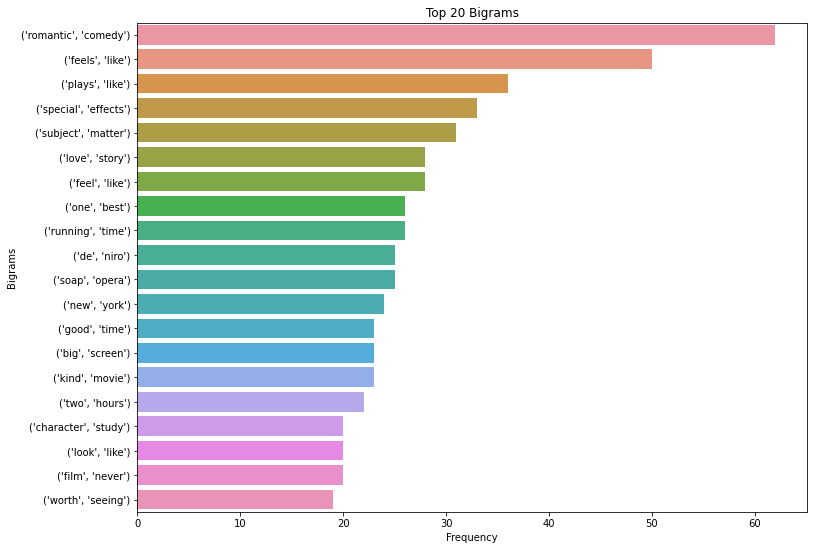

In [ ]:
from nltk.util import ngrams

bigrams = sentences.apply(lambda x: ngrams(x,2))
bi_grams = bigrams.apply(lambda x: list(x))
top_20_bigrams = Counter(itertools.chain.from_iterable(bi_grams)).most_common(20)

top_bigram = pd.DataFrame(top_20_bigrams, columns=['bigram', 'frequency'])
top_bigram.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=top_bigram.frequency, y=top_bigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams')
plt.show()

In [ ]:
def get_bigram(sentences):
  bigrams = sentences.apply(lambda x: ngrams(x,2))
  bi_grams = bigrams.apply(lambda x: list(x))
  top_20_bigrams = Counter(itertools.chain.from_iterable(bi_grams)).most_common(20)

  top_bigram = pd.DataFrame(top_20_bigrams, columns=['bigram', 'frequency'])
  top_bigram.set_index('bigram', inplace=True)

  return top_bigram

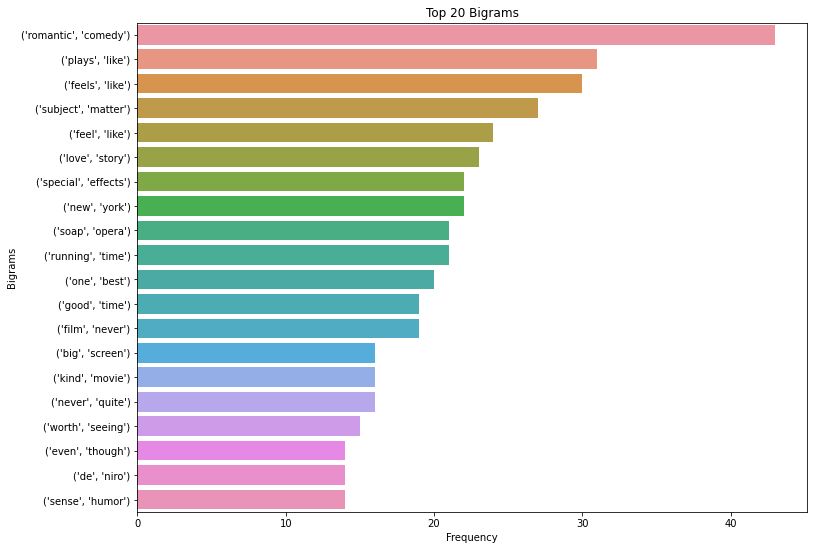

In [ ]:
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=train_top_bigram.frequency, y=train_top_bigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams')
plt.show()

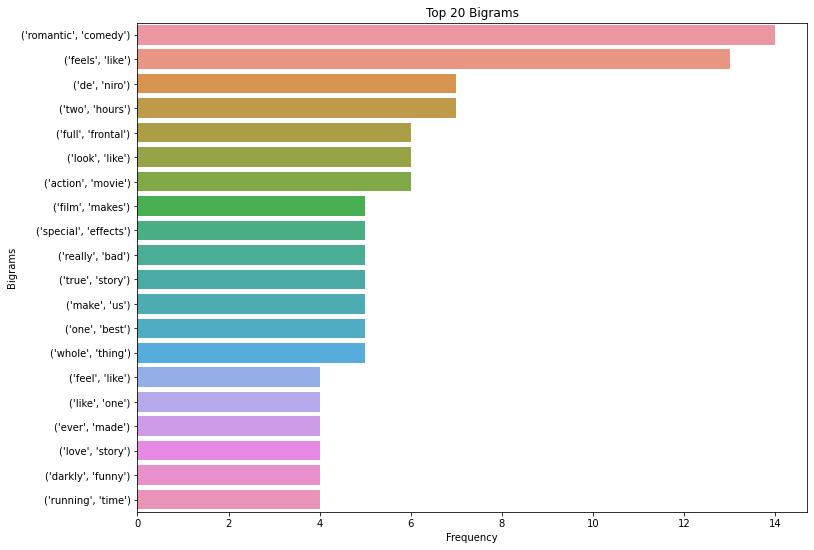

In [ ]:
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=test_top_bigram.frequency, y=test_top_bigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams')
plt.show()

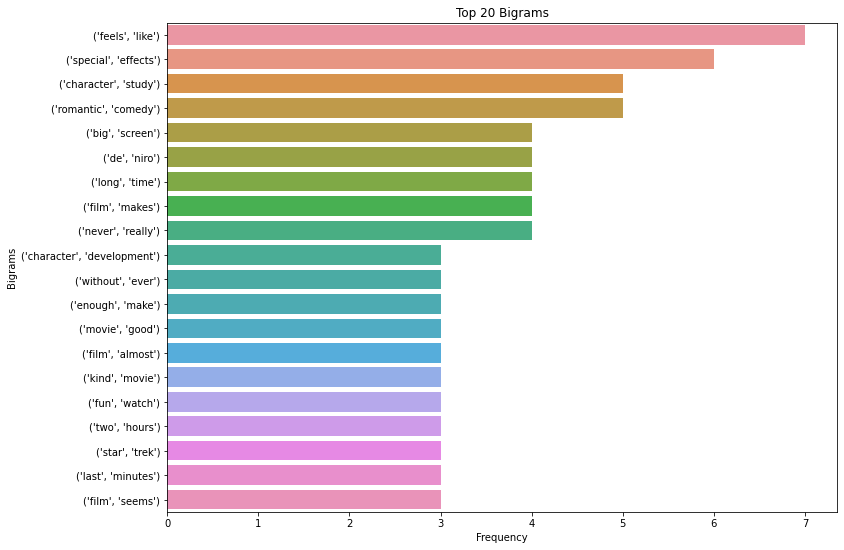

In [ ]:
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=eval_top_bigram.frequency, y=eval_top_bigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams')
plt.show()

#### Trigrams

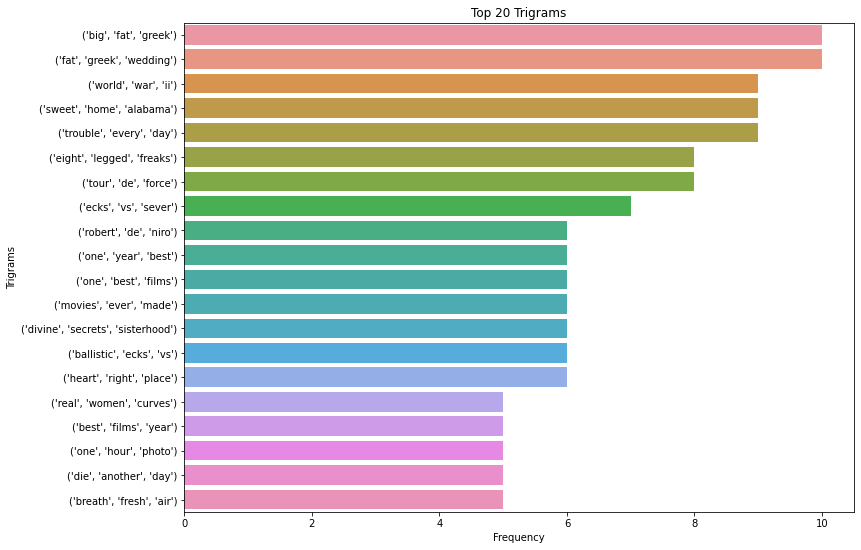

In [ ]:
trigrams = sentences.apply(lambda x: ngrams(x,3))
tri_grams = trigrams.apply(lambda x: list(x))
top_20_trigrams = Counter(itertools.chain.from_iterable(tri_grams)).most_common(20)
top_trigram = pd.DataFrame(top_20_trigrams, columns=['bigram', 'frequency'])
top_trigram.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(12,9))
_ = sns.barplot(x=top_trigram.frequency, y=top_trigram.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Trigrams')
_ = plt.title('Top 20 Trigrams')
plt.show()

#### Wordclouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, label=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
    wordcloud=wordcloud.generate(' '.join(data.values.sum()))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title(label)
    plt.imshow(wordcloud)
    plt.show()

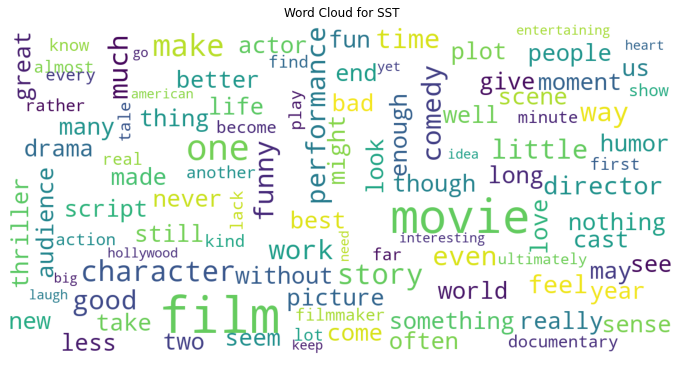

In [ ]:
show_wordcloud(sentences, 'Word Cloud for SST')

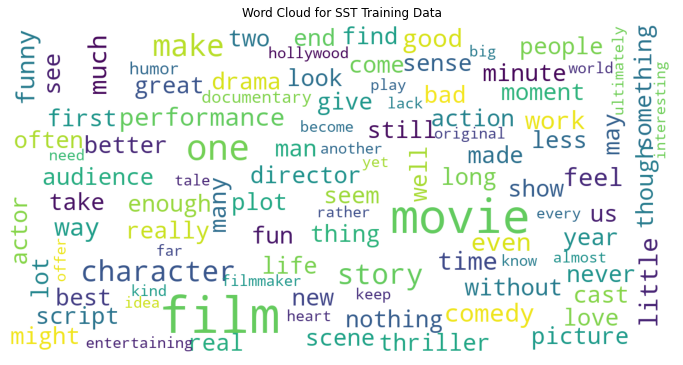

In [ ]:
show_wordcloud(train_sentences, 'Word Cloud for SST Training Data')

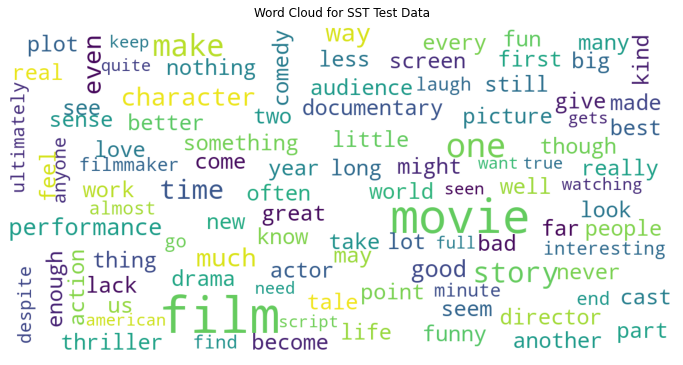

In [ ]:
show_wordcloud(test_sentences, 'Word Cloud for SST Test Data')

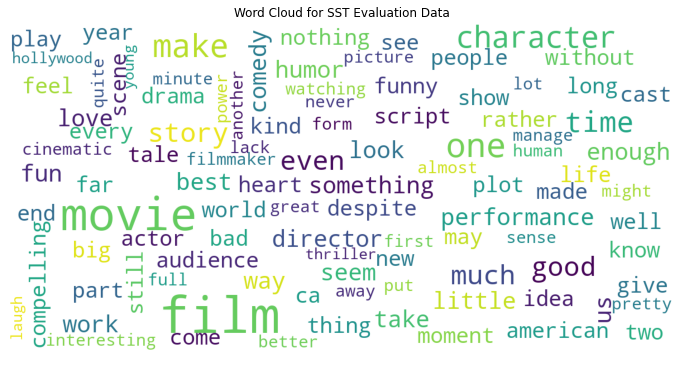

In [ ]:
show_wordcloud(eval_sentences, 'Word Cloud for SST Evaluation Data')